In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import torch
from torch import nn

In [4]:
def getDatadir(dir="D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集"):
    dir=dir+'/'
    data_name=os.listdir(dir)
    data_dir=[]
    len_name=len(data_name)
    for i in range(len_name):
        data_dir.append(dir+data_name[i])
        #data_dir    
        data_dir_copy=data_dir.copy()
        #random.shuffle(data_dir_copy )
        Data_dir=data_dir_copy
        #Data_dir是所有数据的地址
    return Data_dir

In [5]:
Data_dir=getDatadir()
Data_dir

['D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data0.txt',
 'D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data1.txt',
 'D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data2.txt',
 'D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data3.txt',
 'D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data4.txt',
 'D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data5.txt',
 'D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data6.txt',
 'D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data7.txt',
 'D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data8.txt']


数据可视化

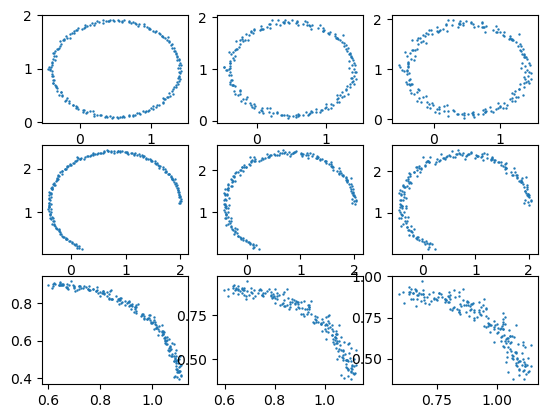

In [21]:
fig_r=(len(Data_dir)//3)+((len(Data_dir)%3)!=0);fig_c=3
for i in range(fig_r):
    for j in range(fig_c):
        plt.subplot(fig_c,fig_r,j*fig_r+i+1)
        with open(Data_dir[j*fig_r+i]) as f:
            con=f.readline()
            x,y=[],[]
            while con!="": 
                xt,yt=con.split(" ")
                x.append(float(xt));y.append(float(yt))
                con=f.readline()
        plt.scatter(x,y,s=0.5)

In [8]:
def initial(Z):
    n=Z.shape[0]
    w=np.array([-np.random.uniform(0,5),-np.random.uniform(0,5),1])
    m=np.random.rand()
    a_Pv,a_Nv=np.random.uniform(0,5,(1,n)),np.random.uniform(0,5,(1,n))
    B_Pv,B_Nv=np.random.uniform(0,5,(1,n)),np.random.uniform(0,5,(1,n))
    #print("a_Pv,a_Nv,B_Pv,B_Nv:","\n",a_Pv,"\n",a_Nv,"\n",B_Pv,"\n",B_Nv)
    E_Pv,E_Nv=np.random.rand(1,n),np.random.rand(1,n)###松弛变量ξ用随机值初始化效果比用ξ=|(np.dot(w,z)+m)-ε|+1好，why?  #运行速度比网上的慢三倍，why?
    ini_para={"w":w,
              "m":m,
              "a_Pv":a_Pv,
              "a_Nv":a_Nv,
              "B_Pv":B_Pv,
              "B_Nv":B_Nv,
              "E_Pv":E_Pv,
              "E_Nv":E_Nv}
    return ini_para   


In [9]:
def grads_x(Z,C,parameters):
    w=parameters["w"]
    m=parameters["m"]
    E_Pv=parameters["E_Pv"]
    B_Pv=parameters["B_Pv"]
    E_Nv=parameters["E_Nv"]
    B_Nv=parameters["B_Nv"]
    a_Pv=parameters["a_Pv"]
    a_Nv=parameters["a_Nv"]
    
    dJ_w=w+(np.diag(a_Pv[0]).dot(Z)-np.diag(a_Nv[0]).dot(Z)).sum(axis=0)
    dJ_m=np.sum(a_Pv-a_Nv)
    dJ_E_Pv=C-a_Pv-B_Pv
    dJ_E_Nv=C-a_Nv-B_Nv
    grads={"dJ_w":dJ_w,
           "dJ_m":dJ_m,
           "dJ_E_Pv":dJ_E_Pv,
           "dJ_E_Nv":dJ_E_Nv}
    return grads


In [10]:
def grads_lamda(Z,C,parameters,ε=0.01):#e代表ε
    w=parameters["w"]
    m=parameters["m"]
    E_Pv=parameters["E_Pv"]
    B_Pv=parameters["B_Pv"]
    E_Nv=parameters["E_Nv"]
    B_Nv=parameters["B_Nv"]
    a_Pv=parameters["a_Pv"]
    a_Nv=parameters["a_Nv"]
    dJ_B_Pv=-E_Pv
    dJ_B_Nv=-E_Nv
    dJ_a_Pv=np.dot(Z,w)+m-ε-E_Pv
    dJ_a_Nv=-np.dot(Z,w)-m-ε-E_Nv
    grads={"dJ_B_Pv":dJ_B_Pv,
           "dJ_B_Nv":dJ_B_Nv,
           "dJ_a_Pv":dJ_a_Pv,
           "dJ_a_Nv":dJ_a_Nv}
    return grads

In [11]:
def getdata(dir,expand=True):
    data=[]
    with open(dir) as f:
            con=f.readline()
            #x,y=[],[]
            while con!="": 
                xt,yt=con.split(" ")
                x=(float(xt));y=(float(yt))
                if expand==True:
                     dat=[x,y,x**2+y**2]
                else:
                     dat=[x,y]     
                data.append(dat)
                con=f.readline()
    return data


In [12]:
def update_para_x(parameters, grads, learning_rate):
    w=parameters['w']
    m=parameters['m']
    E_Pv=parameters['E_Pv']
    E_Nv=parameters['E_Nv']
    dJ_w = grads['dJ_w']
    dJ_m = grads['dJ_m']
    dJ_E_Pv = grads['dJ_E_Pv']
    dJ_E_Nv = grads['dJ_E_Nv']
    #w = dJ_w#
    w = w - learning_rate * dJ_w
    w[2]=1
    m = m - learning_rate * dJ_m
    E_Pv = E_Pv - learning_rate * dJ_E_Pv
    E_Nv = E_Nv - learning_rate * dJ_E_Nv
    parameters = {'w':w,
                  'm':m,
                  'E_Pv':E_Pv,
                  'E_Nv':E_Nv,
                  }
    return parameters




In [13]:
def update_para_lamda(parameters, grads, learning_rate):
    B_Pv=parameters['B_Pv']
    B_Nv=parameters['B_Nv']
    a_Pv=parameters['a_Pv']
    a_Nv=parameters['a_Nv']
    dJ_B_Pv = grads['dJ_B_Pv']
    dJ_B_Nv = grads['dJ_B_Nv']
    dJ_a_Pv = grads['dJ_a_Pv']
    dJ_a_Nv = grads['dJ_a_Nv']
    B_Pv = B_Pv + learning_rate * dJ_B_Pv
    B_Nv = B_Nv + learning_rate * dJ_B_Nv
    a_Pv = a_Pv + learning_rate * dJ_a_Pv
    a_Nv = a_Nv + learning_rate * dJ_a_Nv
    parameters = {'B_Pv':B_Pv,
                  'B_Nv':B_Nv,
                  'a_Pv':a_Pv,
                  'a_Nv':a_Nv,
                  }
    return parameters

In [14]:
def train(Z,C=0,lr_rate=0.01,n=100000,epsilon=0.01):
    if C==0:
        C=np.random.random()
    num_z=Z.shape[0]
    parameters=initial(Z)
    parameters_x={}
    #print(parameters["m"])
    for j in tqdm(range(n)):
        grad_x=grads_x(Z,C,parameters)
        #print(grad_x["dJ_m"])
        parameters_x=update_para_x(parameters,grad_x,lr_rate)
        parameters["w"]=parameters_x["w"]
        parameters["m"]=parameters_x["m"]
        #print(parameters_x["w"])
        parameters["E_Pv"]=parameters_x["E_Pv"]
        parameters["E_Nv"]=parameters_x["E_Nv"]
        #
        grad_y=grads_lamda(Z,C,parameters,epsilon)
        parameters_y=update_para_lamda(parameters,grad_y,lr_rate)
        dit={}
        dit.update(parameters_x);dit.update(parameters_y)
        parameters=dit
        
    w=parameters["w"];m=parameters["m"]
    a=-w[0]/2;b=-w[1]/2;r=math.sqrt(abs(a**2+b**2-m))
    return a,b,r



In [19]:

def show(circle_dat,i=0):
    a,b,r=circle_dat[0],circle_dat[1],circle_dat[2]
    circle = Circle((a, b), radius=r, facecolor="white", edgecolor="#000000")
    figure, ax = plt.subplots()
    ax.add_patch(circle)
    ax.set_xlim(-1.5, 2.5)
    ax.set_ylim(-0.5, 2.5)

    with open(Data_dir[i]) as f:
                con=f.readline()
                x,y=[],[]
                while con!="": 
                    xt,yt=con.split(" ")
                    x.append(float(xt));y.append(float(yt))
                    con=f.readline()
    plt.scatter(x,y,s=0.5)

    plt.show(circle)


100%|██████████| 100000/100000 [00:17<00:00, 5721.31it/s]


0.4901921423642082 0.9918032200887285 0.8939616853959496


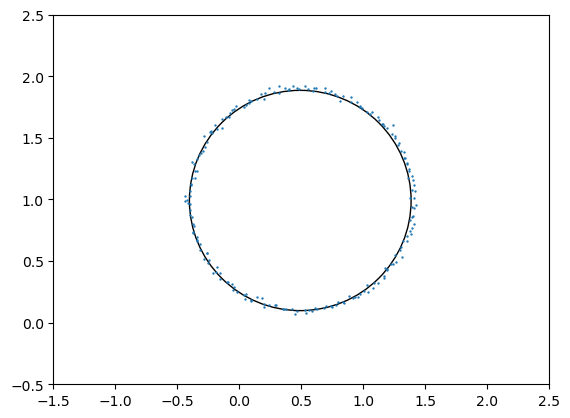

In [55]:
Z=np.array(getdata('D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data0.txt'))
a,b,r=train(Z,0.5,0.001,100000)
print(a,b,r)
c=(a,b,r)
show(c)

In [22]:
#可视化：把拟合的圆和原始数据画在一起
def display(Data_dir,coor):#para:数据集地址；圆心坐标及半径大小
    fig_r=(len(Data_dir)//3)+((len(Data_dir)%3)!=0);fig_c=3
    figure, ax = plt.subplots(fig_c,fig_r)
    for i in range(fig_r):
        for j in range(fig_c):
            #plt.subplot(fig_c,fig_r,j*fig_r+i+1)
            circle = Circle((coor[3*j+i][0], coor[3*j+i][1]), radius=coor[3*j+i][2], facecolor="white", edgecolor="#000000")
            
            ax[j,i].add_patch(circle)
            #ax[j,i].set_xlim(-1.5, 2.5)
            #ax[j,i].set_ylim(-0.5, 2.5)
            plt.subplot(fig_c,fig_r,j*fig_r+i+1)
            with open(Data_dir[j*fig_r+i]) as f:
                con=f.readline()
                x,y=[],[]
                while con!="": 
                    xt,yt=con.split(" ")
                    x.append(float(xt));y.append(float(yt))
                    con=f.readline()
            plt.scatter(x,y,s=0.5)
            plt.axis('square')
            
    plt.show()


In [36]:
#求所有的拟合圆心和半径
coor=[]
for f in Data_dir:
    Z=np.array(getdata(f))
    t=train(Z,0,0.001,100000)
    coor.append([t[0],t[1],t[2]])
coor=np.array(coor)
            

100%|██████████| 100000/100000 [00:18<00:00, 5439.13it/s]


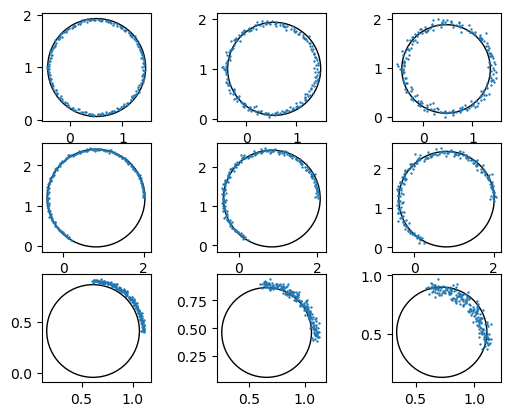

In [37]:
display(Data_dir,coor)

线性回归

In [38]:
def train_lin(Z,n,lr=0.01):
    l=Z.shape[0]
    #initialize
    w=np.random.random(2)
    m=np.random.random()
    print("w,m=",w,m)
    for j in tqdm(range(n)):
        i=j%l
        #grads
        dw=-((Z[i][0]**2+Z[i][1]**2)-w.dot(Z[i])-m)*Z[i]
        dm=-((Z[i][0]**2+Z[i][1]**2)-w.dot(Z[i])-m)
        #print("dw,dm=",dw,dm)
        #update
        w=w-lr*dw
        m=m-lr*dm
        
    a=w[0]/2;b=w[1]/2;r=math.sqrt(abs(-m-a**2-b**2))
        #print("a,b,r=",a,b,r)

    return a,b,r


w,m= [0.58753911 0.48722536] 0.368897078812951


100%|██████████| 100000/100000 [00:00<00:00, 127894.15it/s]


0.5029599589594687 1.0021064171878595 0.9083957628409816


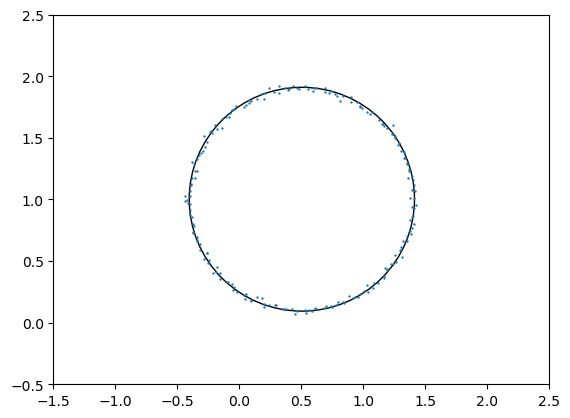

In [47]:
Z2=np.array(getdata('D:/0学习，学个P/模式识别/实验二/模式识别实验二/数据集/data0.txt',False))
a2,b2,r2=train_lin(Z2,100000,0.1)
print(a2,b2,r2)
c2=(a2,b2,r2)
show(c2)

In [45]:
coor2=[]
for f in Data_dir:
    Z2=np.array(getdata(f,False))
    t=train_lin(Z2,100000,0.001)
    coor2.append([t[0],t[1],t[2]])
coor2=np.array(coor2)

w,m= [0.80407258 0.56533269] 0.12965796067069668


100%|██████████| 100000/100000 [00:00<00:00, 127863.12it/s]


w,m= [0.91423198 0.01347066] 0.028757032550974504


100%|██████████| 100000/100000 [00:00<00:00, 138577.12it/s]


w,m= [0.13533959 0.34078485] 0.8731265894148144


100%|██████████| 100000/100000 [00:00<00:00, 143371.77it/s]


w,m= [0.09729215 0.27421312] 0.6775097368623507


100%|██████████| 100000/100000 [00:00<00:00, 142792.74it/s]


w,m= [0.84535209 0.77475516] 0.764396846238671


100%|██████████| 100000/100000 [00:00<00:00, 139955.59it/s]


w,m= [0.958458   0.90736192] 0.686195068627386


100%|██████████| 100000/100000 [00:00<00:00, 137317.86it/s]


w,m= [0.83009306 0.02822274] 0.7352548041585045


100%|██████████| 100000/100000 [00:00<00:00, 135491.74it/s]


w,m= [0.80140587 0.1216756 ] 0.09446599829864721


100%|██████████| 100000/100000 [00:00<00:00, 140315.27it/s]


w,m= [0.7186745  0.96258018] 0.9801888663062736


100%|██████████| 100000/100000 [00:00<00:00, 138257.68it/s]


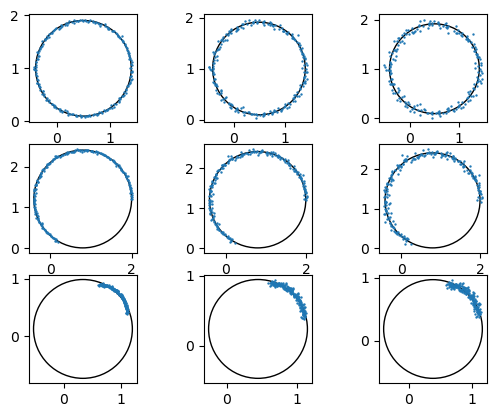

In [46]:
display(Data_dir,coor2)